# 17. 다음에 볼 영화 예측하기 - Movielens 영화 SBR

## __0. IMPORT__

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from datetime import datetime

## __1. DATA__

### __1. DATA Load__

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], 
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
# data를 id와 시간 순서로 정렬해줍니다.
data.sort_values(['UserId', 'Time'], inplace=True)  
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### 2. DATA Preprocessing

 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행  
   
   
 * 주의 할 점 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의

#### 2.1 Session Length

In [4]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
print(f'Median: {session_length.median()}')
print(f'Mean: {session_length.mean()}')
print(f'Minimum: {session_length.min()}')
print(f'Maximum: {session_length.max()}')
print(f'99.9% 세션의 길이: {session_length.quantile(0.999)}')

Median: 96.0
Mean: 165.5975165562914
Minimum: 20
Maximum: 2314
99.9% 세션의 길이: 1343.181000000005


In [6]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

In [7]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [8]:
session_length.min(), session_length.max()

(20, 2314)

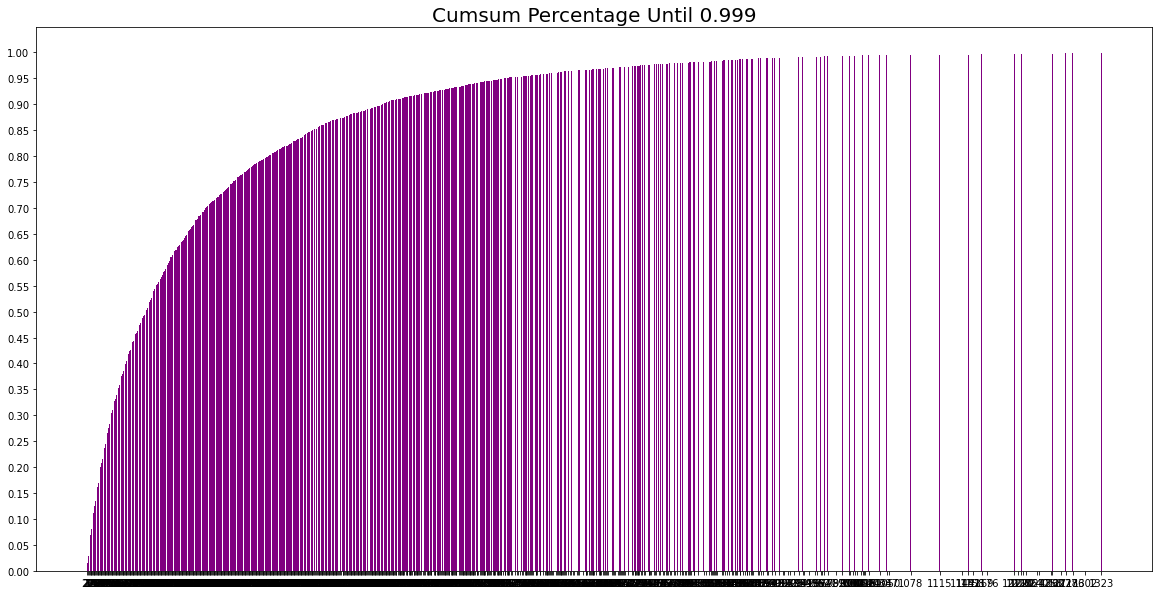

In [9]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='Purple')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### __2. 2 Session Time__

In [10]:
change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


#### __2.3 Rating__

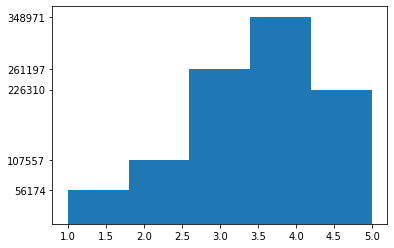

In [12]:
plt.hist(data['Rating'], bins=5)
plt.yticks(data['Rating'].value_counts())
plt.show()

In [13]:
data = data[data['Rating']>=4]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575281 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   UserId  575281 non-null  int32         
 1   ItemId  575281 non-null  int32         
 2   Rating  575281 non-null  int32         
 3   Time    575281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 15.4 MB


#### __2.4 Cleansing__

In [14]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
data = cleanse_recursive(data, shortest=2, least_click=6)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


#### __2.5 DATA Split__

In [16]:
data = data.sort_values('Time')
data.head(20)

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000007,6040,1961,4,2000-04-25 23:06:17
1000192,6040,2019,5,2000-04-25 23:06:17
999868,6040,573,4,2000-04-25 23:07:36
999967,6040,3111,5,2000-04-25 23:07:36
999980,6040,3505,4,2000-04-25 23:07:36
999920,6040,213,5,2000-04-25 23:07:36
999884,6040,912,5,2000-04-25 23:09:51


In [17]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    
    return before_date, after_date

In [18]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [19]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [20]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 562991
	 Sessions: 6034
	 Items: 3062
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 03:58:17

* valid Set Stats Info
	 Events: 6305
	 Sessions: 367
	 Items: 1890
	 First Time : 2002-03-05 04:38:49
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 4773
	 Sessions: 313
	 Items: 1555
	 First Time : 2002-09-01 19:43:16
	 Last Time : 2003-02-28 17:49:50



In [21]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [22]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

#### __3. DATA Pipeline__

#### __3.1 Session Dataset__

In [23]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [24]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999967,6040,3111,5,2000-04-25 23:07:36,6
999980,6040,3505,4,2000-04-25 23:07:36,7
999920,6040,213,5,2000-04-25 23:07:36,8
999884,6040,912,5,2000-04-25 23:09:51,9


In [25]:
tr_dataset.click_offsets

array([     0,     45,    118, ..., 562688, 562778, 562991], dtype=int32)

In [26]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6031, 6032, 6033])

#### __3.2 Session DataLoader__

In [27]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [28]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=5)
tr_dataset.df.head(30)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999967,6040,3111,5,2000-04-25 23:07:36,6
999980,6040,3505,4,2000-04-25 23:07:36,7
999920,6040,213,5,2000-04-25 23:07:36,8
999884,6040,912,5,2000-04-25 23:09:51,9


In [29]:
iter_ex = iter(tr_data_loader)
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  45 116 138 152]
Label Item Idx are :       [  1  46 117 139 153]
Previous Masked Input Idx are []


## __2. MODEL__

### __1. Evaluation Metric__

In [30]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### __2. Model Architecture__

In [31]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [32]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [33]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.49, epochs=5, k=20)

In [34]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3062)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    467100    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3062)               156162    
Total params: 623,262
Trainable params: 623,262
Non-trainable params: 0
_________________________________________________________________


### __3. Model Training__

In [35]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [36]:
train_model(model, args)

Evaluation:   9%|▊         | 2/23 [00:02<00:27,  1.31s/it]


	 - Recall@20 epoch 1: 0.023438
	 - MRR@20    epoch 1: 0.006140



Evaluation:   9%|▊         | 2/23 [00:02<00:24,  1.17s/it]


	 - Recall@20 epoch 2: 0.025391
	 - MRR@20    epoch 2: 0.006171



Evaluation:   9%|▊         | 2/23 [00:02<00:24,  1.16s/it]


	 - Recall@20 epoch 3: 0.025391
	 - MRR@20    epoch 3: 0.007968



Evaluation:   9%|▊         | 2/23 [00:02<00:24,  1.15s/it]


	 - Recall@20 epoch 4: 0.037109
	 - MRR@20    epoch 4: 0.008585



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.13s/it]

	 - Recall@20 epoch 5: 0.037109
	 - MRR@20    epoch 5: 0.008574



## __4. Inference__

In [37]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### __1. Trial 0__

In [38]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:01<00:17,  1.12s/it]

	 - Recall@20: 0.035156
	 - MRR@20: 0.007042



### __2. Trial 1__

In [39]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.1, epochs=3, k=20)
train_model(model, args)

Evaluation:   9%|▊         | 2/23 [00:02<00:24,  1.14s/it]


	 - Recall@20 epoch 1: 0.037109
	 - MRR@20    epoch 1: 0.008574



Evaluation:   9%|▊         | 2/23 [00:02<00:24,  1.16s/it]


	 - Recall@20 epoch 2: 0.037109
	 - MRR@20    epoch 2: 0.008574



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.14s/it]

	 - Recall@20 epoch 3: 0.037109
	 - MRR@20    epoch 3: 0.008574



In [40]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:01<00:18,  1.15s/it]

	 - Recall@20: 0.035156
	 - MRR@20: 0.007042



### __3. Trial 2__

In [41]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.23132, lr=0.1, epochs=3, k=20)
train_model(model, args)

Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.14s/it]


	 - Recall@20 epoch 1: 0.037109
	 - MRR@20    epoch 1: 0.008574



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.12s/it]


	 - Recall@20 epoch 2: 0.037109
	 - MRR@20    epoch 2: 0.008574



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.13s/it]

	 - Recall@20 epoch 3: 0.037109
	 - MRR@20    epoch 3: 0.008574



In [42]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:01<00:17,  1.10s/it]

	 - Recall@20: 0.035156
	 - MRR@20: 0.007042



## 5. Retrospection

어느덧 마지막 익스에 도달했다.  
내일 부터 고잉디퍼를 빡세개 나가야 한다는 생각에 벌써부터 눈동자가 흔들리지만.. 내가 선택 한 길이라는 생각에 악으로 깡으로 버티겠습니다.  
인공지능 알고리즘을 활용한 추천 시스템에 대한 2번째 익스 인 것 같습니다.  
이런 식이라면 최근 매일 같이 개발자 양성을 위한 맞춤형 광고의 원리가 어느 정도 이해가 된다고 생각합니다.  
또한 이번 모델의 경우 상당히 가벼워 보이지만 원리는 그렇지 못 하다고 생각합니다.  
그래서 학습의 시간이 많이 소요될 것이라고 생각 됩니다.